THIS PROGRAM USES ANN called LSTM to predict the closing price of stock of APPLE using past 60 days price

In [0]:
#import libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
#Get the stock price values
df=web.DataReader('AAPL',data_source='yahoo',start='2012-01-01', end='2019-12-17')
#show data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,58.928570,58.428570,58.485714,58.747143,75555200.0,50.857235
2012-01-04,59.240002,58.468571,58.571430,59.062859,65005500.0,51.130558
2012-01-05,59.792858,58.952858,59.278572,59.718571,67817400.0,51.698215
2012-01-06,60.392857,59.888573,59.967144,60.342857,79573200.0,52.238651
2012-01-09,61.107143,60.192856,60.785713,60.247143,98506100.0,52.155792
...,...,...,...,...,...,...
2019-12-11,271.100006,268.500000,268.809998,270.769989,19689200.0,269.399658
2019-12-12,272.559998,267.320007,267.779999,271.459991,34327600.0,270.086151
2019-12-13,275.299988,270.929993,271.459991,275.149994,33396900.0,273.757477


In [4]:
df.shape

(2003, 6)

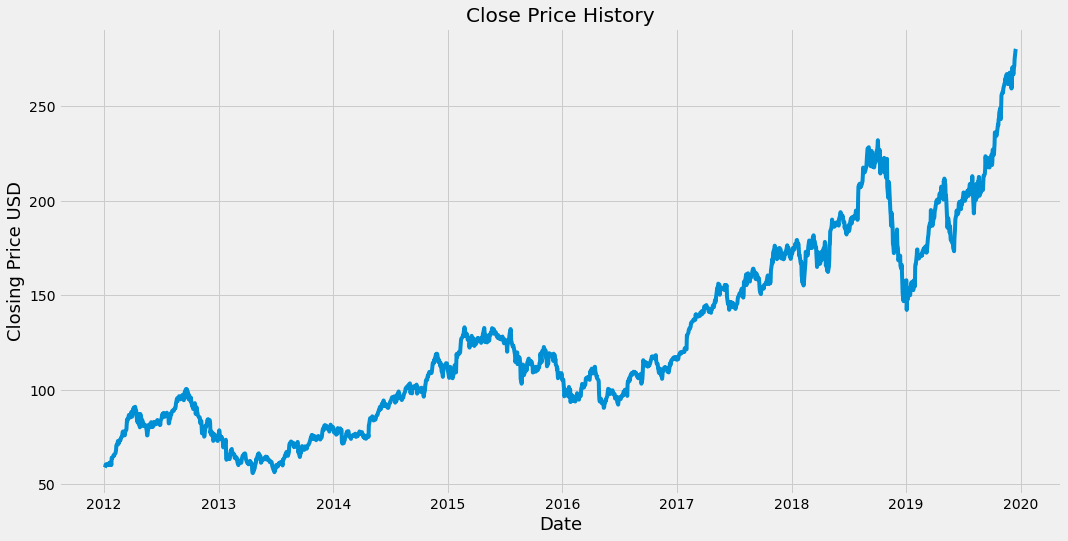

In [5]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price USD', fontsize=18)
plt.show()

In [0]:
#Create new df with only Close cloumn
data= df.filter(['Close'])

#COnvert the df into numpy array
dataset=data.values

#Get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)

In [0]:
#Scale all the data to be values bw 0 and 1
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)

In [0]:
#Create the scaled training data set
train_data= scaled_data[0:training_data_len, :]

#Split the data into x_train and y_train data sets
x_train=[]
y_train= []
for i in range(60,len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

In [0]:
#convert x train y train to numpy arrays
x_train, y_train=np.array(x_train), np.array(y_train)

In [0]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [0]:
#Build LSTM model
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [0]:
#Compile the model
model.compile(optimizer= 'adam', loss='mean_squared_error')

In [15]:
#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
1543/1543 [==============================] - 51s 33ms/step - loss: 6.1163e-04


In [0]:
#Test data set
test_data= scaled_data[training_data_len - 60: , :]

#Create x_test and y_test data sets
x_test = []
y_test = dataset[training_data_len : , :]
#GEt all of the rows from index 1603 to the rest and all of the columns(in this case, only 'Close'), so 2003-1603 = 400 rows of data
for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [0]:
#convert x_test to numpy array
x_test=np.array(x_test)

In [0]:
#Reshape the data into the shape accepted by LSTM-number of samples, number of time steps, number of features
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [0]:
#Getting model predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions) #Undo the scaling

In [21]:
#Calculate the value of RMSE
rmse=np.sqrt(np.mean(((predictions - y_test)**2)))
rmse

7.109934899057559

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


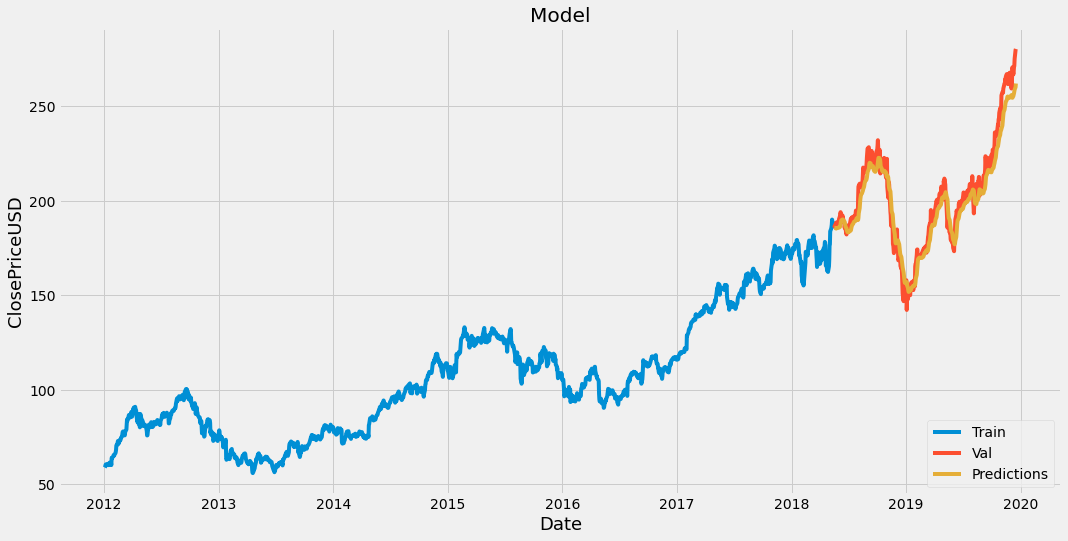

In [26]:
#PLot data
train=data[:training_data_len]
valid=data[training_data_len:]
valid['Predictions'] = predictions

#Visalize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('ClosePriceUSD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close' , 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [27]:
#Show the valid and predicted prices
valid

,Close,Predictions
Date,,
2018-05-17,186.990005,185.748550
2018-05-18,186.309998,185.724731
2018-05-21,187.630005,185.494339
2018-05-22,187.160004,185.385834
2018-05-23,188.360001,185.286865
...,...,...
2019-12-11,270.769989,256.942566
2019-12-12,271.459991,257.886108
2019-12-13,275.149994,258.856903


In [28]:
#Get the quote
apple_quote = web.DataReader('AAPL',data_source='yahoo' , start='2012-01-01', end='2019-12-17')

#Create a new df
new_df= apple_quote.filter(['Close'])

#Get the last 60 days closing price
last_60_days = new_df[-60:].values

#Scale the data to be values bw 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)

#Create an empty list
X_test= []

#Append the past 60 days
X_test.append(last_60_days_scaled)

#Converrt the X_Test_dataset to numpy array
X_test= np.array(X_test)

#Reshape the data
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))

#Get the predicted scaled price
pred_price = model.predict(X_test)

#undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[264.03745]]


In [29]:
#Lets see the actual price quote
apple_quote2 = web.DataReader('AAPL',data_source='yahoo',start='2019-12-18', end='2019-12-18')

print(apple_quote2['Close'])

Date
2019-12-18    279.73999
Name: Close, dtype: float64
